# Gaussian Mixture Modeling + Principal Component Analysis

In [25]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import csv
import string
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

In [3]:
df_train = pd.read_csv('./train_users_2.csv')
df_test = pd.read_csv('./test_users.csv')
id_test = df_test['id']
labels = df_train['country_destination'].values
df_train = df_train.drop(['country_destination'], axis=1)
piv_train = df_train.shape[0]

In [4]:
# split date fields into 3 columns (year, month, day) to avoid having a feature for every possible date
dac = np.vstack(df_train.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('/')))).values)
df_train['acct_create_month'] = dac[:,0]
df_train['acct_create_day'] = dac[:,1]
df_train['acct_create_year'] = dac[:,2]

# train and test data use different formats, so this is doing the same thing as above
dac = np.vstack(df_test.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
df_test['acct_create_month'] = dac[:,1]
df_test['acct_create_day'] = dac[:,2]
df_test['acct_create_year'] = dac[:,0]

# concatenate the train and test user files
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

# concat account create month/year
df_all['acct_create_month_year'] = df_all.acct_create_month.astype(str) +'/'+ df_all.acct_create_year.astype(str)

# drop columns unecessary for prediction
df_all = df_all.drop(['id', 'date_first_booking','date_account_created','timestamp_first_active','acct_create_day','acct_create_month','acct_create_year'], axis=1)

#set unknown gender values to NA
df_all.gender = df_all.gender.replace('-unknown-',np.nan)

#fill NA values with -1
df_all = df_all.fillna(-1)

# The age field is populated with some outlying values and some year values (e.g., 2014)
# This will pull only ages between 14 and 100
av = df_all.age.values
df_all['age'] = np.where(np.logical_or(av<14, av>100), -1, av)

# encode categorical features with dummy values
categorical = ['acct_create_month_year', 'age', 'gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in categorical:
    df_all_dummy = pd.get_dummies(df_all[f], prefix=f)
    df_all = df_all.drop([f], axis=1)
    df_all = pd.concat((df_all, df_all_dummy), axis=1)

In [6]:
# After cleansing, split the data back up between the train and test users
vals = df_all.values
train_vals = vals[:piv_train]
test_vals = vals[piv_train:]

In [7]:
# Split training values between train & dev sets 

np.random.seed(0)
msk = np.random.rand(len(train_vals)) < 0.75
train = train_vals[msk]
train_labs = labels[msk]
le = LabelEncoder()
y = le.fit_transform(train_labs) 
dev = train_vals[~msk]
dev_labs = labels[~msk]

In [8]:
df_all.shape

(275547, 298)

# Plot the incremental increase in explained variance as the number of components increases

90% explained variance achieved at: 57 components


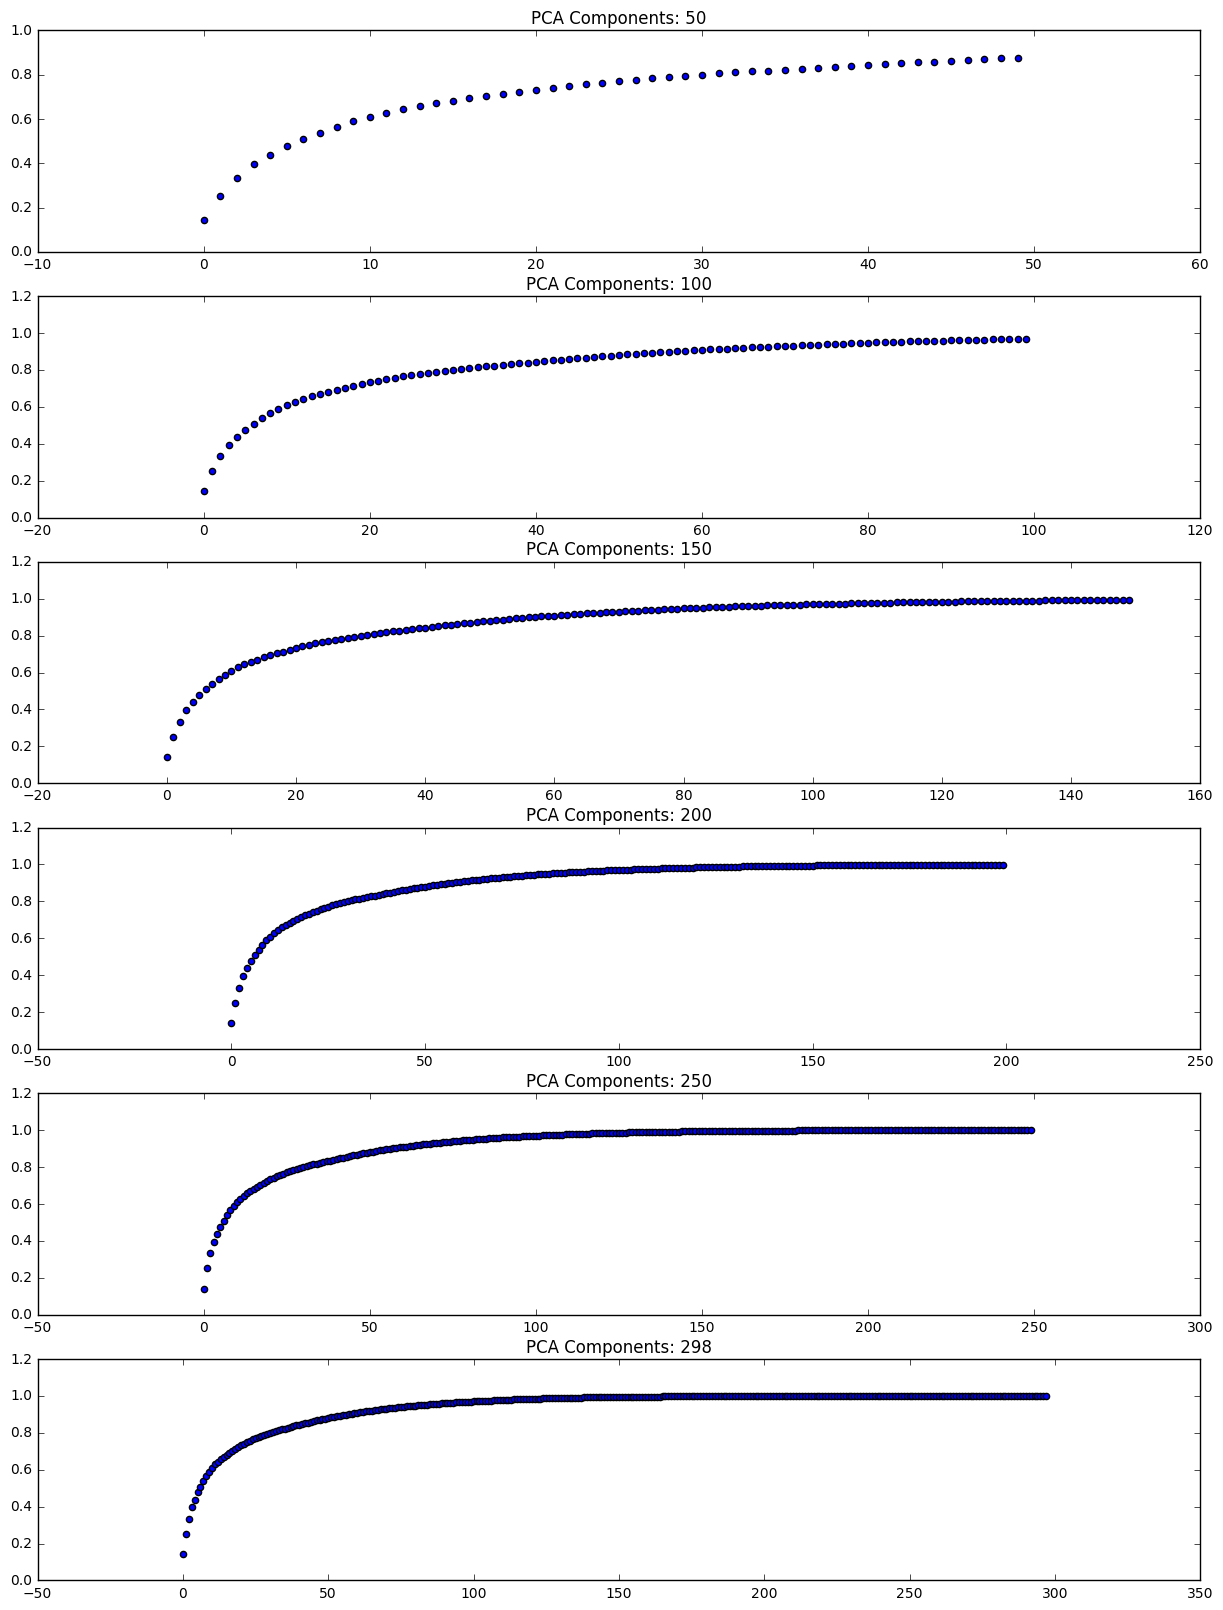

In [112]:
pca_feat = [50,100,150,200,250,298]
plt.figure(figsize=(15,20))

# Loop through the pca component values
for i in range(len(pca_feat)):
    
    # Fit PCA
    k_pca = PCA(n_components=pca_feat[i]).fit(df_all)
    
    # Establish temporary variables
    cum_vars = []
    p1_cum_var = 0
    target=0
    
    # Create Subplot
    ax = plt.subplot(len(pca_feat),1,i+1)
    
    # loop through each individual PCA component and create a list of the 
    # incremental increases of explained variance
    for k in range(pca_feat[i]):
        p1_cum_var += k_pca.explained_variance_ratio_[k]
        cum_vars.append(p1_cum_var)
        
        # Identify the point where we have 90% explained variance
        if((p1_cum_var >= 0.9) & (target==0)):
            target = k 
        
    # Plot the data
    plt.scatter(range(pca_feat[i]),cum_vars)
    plt.title("PCA Components: %s" % pca_feat[i])
print "90% explained variance achieved at:", target, "components"
plt.show()

# Plot the scatter of each country's training data from a 2-dimension PCA

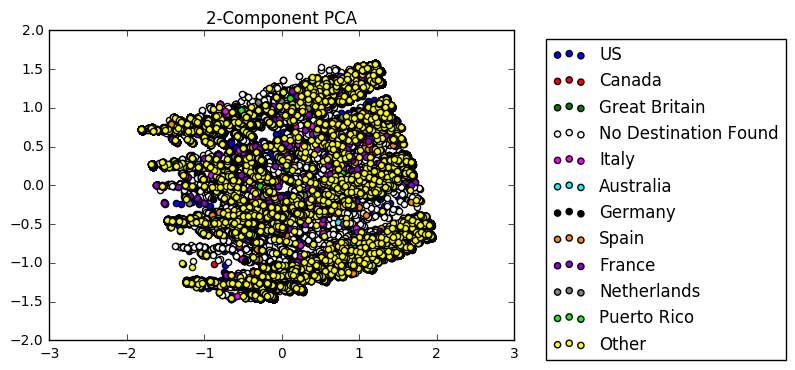

In [122]:
# Fit 2-dimensional PCA
pca_2d=PCA(n_components=2)
pca_train = pca_2d.fit_transform(train)

# Split 2d PCA data into poisonous and not-poisonous sets
pca_train_US = pca_train[np.where(train_labs=='US')]
pca_train_CA = pca_train[np.where(train_labs=='CA')]
pca_train_GB = pca_train[np.where(train_labs=='GB')]
pca_train_NDF = pca_train[np.where(train_labs=='NDF')]
pca_train_IT = pca_train[np.where(train_labs=='IT')]
pca_train_AU = pca_train[np.where(train_labs=='AU')]
pca_train_DE = pca_train[np.where(train_labs=='DE')]
pca_train_ES = pca_train[np.where(train_labs=='ES')]
pca_train_FR = pca_train[np.where(train_labs=='FR')]
pca_train_NL = pca_train[np.where(train_labs=='NL')]
pca_train_PT = pca_train[np.where(train_labs=='PT')]
pca_train_other = pca_train[np.where(train_labs=='other')]

# Plot the data
plt.scatter(pca_train_US[:,0],pca_train_US[:,1],c='blue',label="US")
plt.scatter(pca_train_CA[:,0],pca_train_CA[:,1],c='red',label="Canada")
plt.scatter(pca_train_GB[:,0],pca_train_GB[:,1],c='green',label="Great Britain")
plt.scatter(pca_train_NDF[:,0],pca_train_NDF[:,1],c='white',label="No Destination Found")
plt.scatter(pca_train_IT[:,0],pca_train_IT[:,1],c='magenta',label="Italy")
plt.scatter(pca_train_AU[:,0],pca_train_AU[:,1],c='cyan',label="Australia")
plt.scatter(pca_train_DE[:,0],pca_train_DE[:,1],c='black',label="Germany")
plt.scatter(pca_train_ES[:,0],pca_train_ES[:,1],c='darkorange',label="Spain")
plt.scatter(pca_train_FR[:,0],pca_train_FR[:,1],c='darkviolet',label="France")
plt.scatter(pca_train_NL[:,0],pca_train_NL[:,1],c='gray',label="Netherlands")
plt.scatter(pca_train_PT[:,0],pca_train_PT[:,1],c='lime',label="Puerto Rico")
plt.scatter(pca_train_other[:,0],pca_train_other[:,1],c='yellow',label="Other")


plt.legend(bbox_to_anchor=(1.05, 1),loc=2)
plt.title("2-Component PCA")
plt.show()

# Make predictions using PCA and GMM scores

In [140]:
def GMM_Predict(pca_feat, gmm_comp, cov_type,test_data):
    k_pca = PCA(n_components=pca_feat)

    pca_train = k_pca.fit_transform(train)
    pca_dev = k_pca.transform(test_data)
    
    pca_train_US = pca_train[np.where(train_labs=='US')]
    pca_train_CA = pca_train[np.where(train_labs=='CA')]
    pca_train_GB = pca_train[np.where(train_labs=='GB')]
    pca_train_NDF = pca_train[np.where(train_labs=='NDF')]
    pca_train_IT = pca_train[np.where(train_labs=='IT')]
    pca_train_AU = pca_train[np.where(train_labs=='AU')]
    pca_train_DE = pca_train[np.where(train_labs=='DE')]
    pca_train_ES = pca_train[np.where(train_labs=='ES')]
    pca_train_FR = pca_train[np.where(train_labs=='FR')]
    pca_train_NL = pca_train[np.where(train_labs=='NL')]
    pca_train_PT = pca_train[np.where(train_labs=='PT')]
    pca_train_other = pca_train[np.where(train_labs=='other')]

    US_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_US)
    CA_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_CA)
    GB_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_GB)
    NDF_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_NDF)
    IT_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_IT)
    AU_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_AU)
    DE_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_DE)
    ES_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_ES)
    FR_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_FR)
    NL_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_NL)
    PT_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_PT)
    other_gmm = GaussianMixture(n_components=gmm_comp,covariance_type=cov_type).fit(pca_train_other)

    gmm_preds = []
    score_label = ['US','CA','GB','NDF','IT','AU','DE','ES','FR','NL','PT','other']
    for i in range(len(pca_dev)):
        scores = []
        scores.append(US_gmm.score(pca_dev[i]))
        scores.append(CA_gmm.score(pca_dev[i]))
        scores.append(GB_gmm.score(pca_dev[i]))
        scores.append(NDF_gmm.score(pca_dev[i]))
        scores.append(IT_gmm.score(pca_dev[i]))
        scores.append(AU_gmm.score(pca_dev[i]))
        scores.append(DE_gmm.score(pca_dev[i]))
        scores.append(ES_gmm.score(pca_dev[i]))
        scores.append(FR_gmm.score(pca_dev[i]))
        scores.append(NL_gmm.score(pca_dev[i]))
        scores.append(PT_gmm.score(pca_dev[i]))
        scores.append(other_gmm.score(pca_dev[i]))
        optimal_idx = np.where(scores==max(scores))[0][0]
        gmm_preds.append(score_label[optimal_idx])
    
#     #predict Test data labels
#     gmm_test_preds
#     for j in range(len(pca_test)):
#         test_scores = []
#         test_scores.append(US_gmm.score(pca_test[j]))
#         test_scores.append(CA_gmm.score(pca_test[j]))
#         test_scores.append(GB_gmm.score(pca_test[j]))
#         test_scores.append(NDF_gmm.score(pca_test[j]))
#         test_scores.append(IT_gmm.score(pca_test[j]))
#         test_scores.append(AU_gmm.score(pca_test[j]))
#         test_scores.append(DE_gmm.score(pca_test[j]))
#         test_scores.append(ES_gmm.score(pca_test[j]))
#         test_scores.append(FR_gmm.score(pca_test[j]))
#         test_scores.append(NL_gmm.score(pca_test[j]))
#         test_scores.append(PT_gmm.score(pca_test[j]))
#         test_scores.append(other_gmm.score(pca_test[j]))
#         optimal_idx = np.where(test_scores==max(test_scores))[0][0]
#         gmm_test_preds.append(score_label[optimal_idx])
        
    return(gmm_preds)
    # Calculate accuracy of predictions
print "GMM Prediction Accuracy:", round(np.mean(GMM_Predict(2,4,'full',dev)==dev_labs),4)*100

GMM Prediction Accuracy: 27.35


In [ ]:
le = LabelEncoder().fit(train_labs)
#Taking the 5 classes with highest probabilities
user_ids = []  #list of ids
countries = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    user_ids += [idx] * 5
    countries += le.inverse_transform(np.argsort(test_preds[i])[::-1])[:5].tolist()

In [ ]:
# Generate Kaggle Submission

sub = pd.DataFrame(np.column_stack((user_ids, countries)), columns=['id', 'country'])
sub.to_csv('sub_MODELNAME.csv',index=False)

# Look at a single example and notice that the largest GMM score is significantly greater than those below it.

In [135]:
def param_check(cov_type, dim, comp):
    if cov_type=='diag':
        param = ((dim*2)*comp)*2
    elif cov_type=='spherical':
        param = ((dim+1)*comp)*2
    elif cov_type=='full':
        param = ((dim+((dim*(dim+1))/2))*comp)*2
    elif cov_type=='tied':
        param = ((dim*comp)+((dim*(dim+1))/2)*comp)*2    
    return(param)

In [137]:
def optimizeGMM():
    
    #Create empty lists to populate as we go
    accuracies = []
    pca_dims = []
    gmm_comps = []
    cov_types = []
    cov=['full','spherical','diag','tied']

# In the ugly series of for loops below, I am iterating through all of the possible combinations of parameters
# and referencing back to a custom function above called "param_check" to calculate the number of parameters
# For each iteration that is below 50 parameters, I make a call back to P5 to calculate the prediction accuracy with 
# the respective variables.

# I know that there are prebuilt tools for finding optimal values similar to GridSearch, but I'm trying to stay strict to
# the packages provided in the assignment.

# j = PCA Dimensions
# k = GMM Components


    for i in range(len(cov)):
        for j in range(1,5):
            for k in range (1,5):
                if param_check(cov[i],j,k) < 50:
                    pca_dims.append(j)
                    gmm_comps.append(k)
                    cov_types.append(cov[i])
                    accuracies.append(np.mean(GMM_Predict(j,k,cov[i])==dev_labs))

    # After iterating through all possible combinations of parameters
    # I identify the index for the optimal accuracy, and then print out the respective details
    optimal_idx = np.where(accuracies==max(accuracies))[0][0]
    print "Parameters:",param_check(cov_types[optimal_idx], pca_dims[optimal_idx],gmm_comps[optimal_idx])
    print "PCA Dimensions:", pca_dims[optimal_idx]
    print "GMM Components:", gmm_comps[optimal_idx]
    print "Covariance Type:", cov_types[optimal_idx]
    print "Accuracy:", round(accuracies[optimal_idx],5)*100,"%"
    
optimizeGMM()

Parameters: 16
PCA Dimensions: 2
GMM Components: 2
Covariance Type: diag
Accuracy: 38.398 %


In [10]:
dt = DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=0)
dt.fit(train, train_labs)

print 'Accuracy (a decision tree):', dt.score(dev, dev_labs)

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(train, train_labs)

print 'Accuracy (a random forest):', rfc.score(dev, dev_labs)

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=0.1)

abc.fit(train, train_labs)
print 'Accuracy (adaboost with decision trees):', abc.score(dev, dev_labs)


Accuracy (a decision tree): 0.561622668206
Accuracy (a random forest): 0.599489890904
Accuracy (adaboost with decision trees): 0.614346352906


In [9]:
# strengths = {'C': [0.0001,0.001,0.01,0.1,0.3,0.5,1.0]}
# clf_lr = GridSearchCV(LogisticRegression(), strengths, scoring='f1_micro')
clf_lr = LogisticRegression(C=0.0001)
clf_lr.fit(train, train_labs)
preds = clf_lr.predict(dev)
# print "Optimal Regularization Strength:", clf_lr.best_params_
print "LogReg F1:", metrics.f1_score(dev_labs, preds, average='micro')

LogReg F1: 0.59312283576


In [12]:
np.random.seed(1)

# the following can be replaced in a single line with:
# np.random.choice(range(n), size=n, replace=True)
# but I've given the explicit code so you can learn a bit :-)
def bs_sample_index(n):
    bootstrap_sample_index = np.random.rand(n)
    bootstrap_sample_index = np.floor(bootstrap_sample_index * n)
    bootstrap_sample_index = bootstrap_sample_index.astype("int")
    
    return bootstrap_sample_index

# a single iteration of tree bagging

bootstrap_sample_index = bs_sample_index(train.shape[0])

bs_data = train[bootstrap_sample_index, :]
bs_labels = train_labs[bootstrap_sample_index]
    
# without max_feature restriction this is 'tree bagging'
bs_tree = DecisionTreeClassifier(criterion="entropy", splitter="best")
bs_tree.fit(bs_data, bs_labels)

bs_tree_preds = bs_tree.predict(dev)

{'AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other'}

In [37]:
# convert labels into +/- 1; this is just how adaboost likes it :)
train_labs_pm = train_labs * 2 - 1
dev_labs_pm = dev_labs * 2 - 1

# initialize with equal weights on each data point
data_weights = np.ones(train.shape[0]).astype("float") / float(train.shape[0])

# here begins a single learning round
bdtc = DecisionTreeClassifier(max_depth=1)
bdtc.fit(train, train_labs_pm, sample_weight=data_weights)

# you'll need to save bdtc_predictions each iteration of the loop to do final training set predictions
bdtc_predictions = bdtc.predict(train)

# you'll need to save bdtc_predictions_test each iteration of the loop to do final test set predictions
bdtc_predictions_test = bdtc.predict(dev)
    
bdtc_weighted_error_rate = np.sum(data_weights * (1 * (bdtc_predictions != train_labs_pm)).astype("float"))

# you'll need to save error_rate_alpha each iteration of the loop to do all final predictions
error_rate_alpha = np.log((1 - bdtc_weighted_error_rate) / bdtc_weighted_error_rate) / 2
    
# reweighting: how does this emphasize errors?    
data_weights_updated = data_weights * np.exp(-1 * error_rate_alpha * bdtc_predictions * train_labs_pm)
data_weights_updated = data_weights_updated / sum(data_weights_updated)
data_weights = data_weights_updated

TypeError: unsupported operand type(s) for -: 'str' and 'int'

In [97]:
xgb = GradientBoostingClassifier(max_depth=6, learning_rate=0.25, n_estimators=43,
                     subsample=0.6)                  
xgb.fit(train, y)
y_pred = xgb.predict_proba(dev)  

KeyboardInterrupt: 

In [ ]:
#Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

In [81]:
set(preds)

{'NDF'}

In [96]:
# Generate Kaggle Submission

sub = pd.DataFrame(np.column_stack((id_test, preds)), columns=['id', 'country'])
sub.to_csv('sub.csv',index=False)